In [64]:
import supy as sp
import pandas as pd
import numpy as np
from pathlib import Path

In [59]:
p_dir_input = Path("../data/saveairport_base")
p_runcontrol = p_dir_input / "RunControl.nml"
df_state_base = sp.init_supy(p_runcontrol)


2024-03-03 22:35:56,230 - SuPy - INFO - All cache cleared.


In [ ]:
df_forcing = sp.load_forcing_grid(p_runcontrol, 1)

In [11]:
df_output_base, df_state_final = sp.run_supy(df_forcing, df_state_base)

2024-03-03 22:26:39,665 - SuPy - INFO - ====================
2024-03-03 22:26:39,666 - SuPy - INFO - Simulation period:
2024-03-03 22:26:39,667 - SuPy - INFO -   Start: 2004-02-12 00:05:00
2024-03-03 22:26:39,667 - SuPy - INFO -   End: 2004-04-14 21:00:00
2024-03-03 22:26:39,668 - SuPy - INFO - 
2024-03-03 22:26:39,668 - SuPy - INFO - No. of grids: 1
2024-03-03 22:26:39,668 - SuPy - INFO - SuPy is running in serial mode
2024-03-03 22:26:41,779 - SuPy - INFO - Execution time: 2.1 s
2024-03-03 22:26:41,780 - SuPy - INFO - ====================



array([0.1, 0.2, 0.5, 2. , 5. , 0.1, 0.2, 0.5, 2. , 5. , 0.1, 0.2, 0.5,
       2. , 5. , 0.1, 0.2, 0.5, 2. , 5. , 0.1, 0.2, 0.5, 2. , 5. , 0.1,
       0.2, 0.5, 2. , 5. , 0.1, 0.2, 0.5, 2. , 5. ])

In [85]:
df_state_ehc.loc[:, "k_surf"]

ind_dim,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(1, 0)","(1, 1)","(1, 2)","(1, 3)","(1, 4)",...,"(5, 0)","(5, 1)","(5, 2)","(5, 3)","(5, 4)","(6, 0)","(6, 1)","(6, 2)","(6, 3)","(6, 4)"
grid,,,,,,,,,,,,,,,,,,,,,
1,1.1,1.1,1.1,1.1,1.1,1.2,1.1,1.1,1.5,1.6,...,1.2,1.1,1.1,1.5,1.6,1.2,1.1,1.1,1.5,1.6


In [123]:
# EHC as heat storage scheme
df_state_ehc = df_state_base.copy()
df_state_ehc.storageheatmethod = 5

# modify the depth of the vertical layers
ar_depth = np.repeat(np.array([[0.1, 0.1, 0.5, 2, 3]]), 7, axis=0).flatten()
df_state_ehc.loc[:, "dz_surf"] = ar_depth

# modify the heat capacity of the vertical layers
ar_cp = np.repeat(np.array([[2.2, 2.2, 2.2, 2.2, 2.2]])*1e6, 7, axis=0).flatten()
df_state_ehc.loc[:, "cp_surf"] = ar_cp

# modify the thermal conductivity of the vertical layers
ar_k = np.repeat(np.array([[1.1, 1.1, 1.1, 1.1, 1]]) * 1.5, 7, axis=0).flatten()
df_state_ehc.loc[:, "k_surf"] = ar_k

df_output_ehc, df_state_final = sp.run_supy(df_forcing, df_state_ehc)

2024-03-03 22:56:08,767 - SuPy - INFO - ====================
2024-03-03 22:56:08,768 - SuPy - INFO - Simulation period:
2024-03-03 22:56:08,769 - SuPy - INFO -   Start: 2004-02-12 00:05:00
2024-03-03 22:56:08,769 - SuPy - INFO -   End: 2004-04-14 21:00:00
2024-03-03 22:56:08,769 - SuPy - INFO - 
2024-03-03 22:56:08,770 - SuPy - INFO - No. of grids: 1
2024-03-03 22:56:08,770 - SuPy - INFO - SuPy is running in serial mode
2024-03-03 22:56:11,217 - SuPy - INFO - Execution time: 2.4 s
2024-03-03 22:56:11,217 - SuPy - INFO - ====================



<AxesSubplot: xlabel='datetime'>

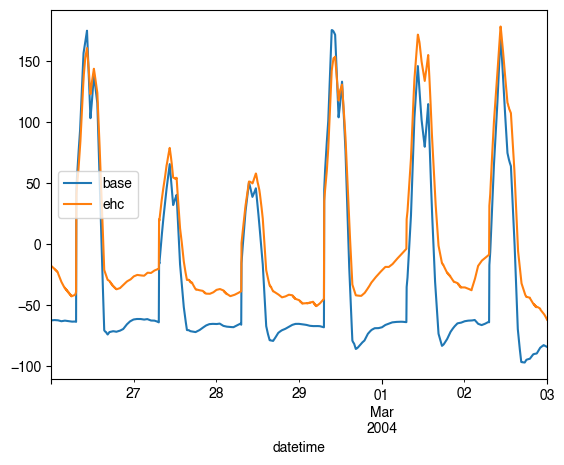

In [124]:
df_comp = (
    pd.concat([df_output_base, df_output_ehc], axis=1, keys=["base", "ehc"])
    .swaplevel(axis=1, i=1, j=0)
    .swaplevel(axis=1, i=1, j=2)
    .sort_index(axis=1)
)
df_comp.loc[1, "SUEWS"].QS.iloc[288 * 14 : 288 * 20].plot()

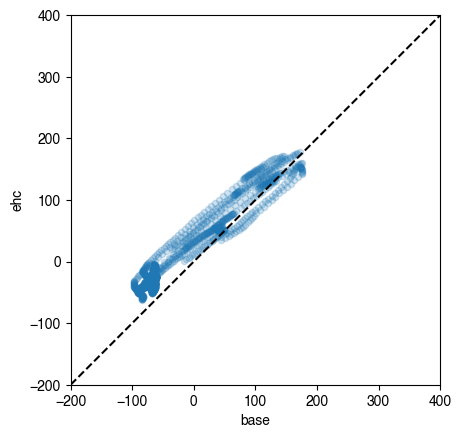

In [125]:
ax = (
    df_comp.loc[1, "SUEWS"]
    .QS.iloc[288 * 14 : 288 * 20]
    .plot.scatter(x="base", y="ehc", alpha=0.2, style="..")
)
_ = ax.set_aspect("equal", "box")
_ = ax.set_xlim(-200, 400)
_ = ax.set_ylim(-200, 400)
_ = ax.plot([-200, 400], [-200, 400], "k--")